# 暂退法（Dropout）

## 1. 重新审视过拟合

当面对更多的特征而样本不足时，线性模型往往会过拟合。
相反，当给出更多样本而不是特征，通常线性模型不会过拟合。
不幸的是，线性模型泛化的可靠性是有代价的。
简单地说，线性模型没有考虑到特征之间的交互作用。
对于每个特征，线性模型必须指定正的或负的权重，而忽略其他特征。

**泛化性**和**灵活性**之间的这种基本权衡被描述为**偏差-方差权衡**（bias-variance tradeoff）。
线性模型有很高的偏差（灵活性低）：它们只能表示一小类函数。
然而，这些模型的方差很低（泛化性高）：它们在不同的随机数据样本上可以得出相似的结果。

**深度神经网络**位于偏差-方差谱的另一端。
与线性模型不同，神经网络并不局限于单独查看每个特征，而是学习特征之间的交互。
例如，神经网络可能推断“尼日利亚”和“西联汇款”一起出现在电子邮件中表示垃圾邮件，
但单独出现则不表示垃圾邮件。

即使我们有比特征多得多的样本，深度神经网络也有可能过拟合。
2017年，一组研究人员通过在随机标记的图像上训练深度网络。
这展示了神经网络的极大灵活性，因为人类很难将输入和随机标记的输出联系起来，
但通过随机梯度下降优化的神经网络可以完美地标记**训练集**中的每一幅图像。
想一想这意味着什么？
假设标签是随机均匀分配的，并且有10个类别，那么分类器在**测试数据**上很难取得高于10%的精度，
那么这里的**泛化差距**就高达90%，如此严重的过拟合。

深度网络的泛化性质令人费解，而这种泛化性质的数学基础仍然是悬而未决的研究问题。
我们鼓励喜好研究理论的读者更深入地研究这个主题。
本节，我们将着重对实际工具的探究，这些工具倾向于改进深层网络的泛化性。

## 2. 扰动的稳健性

我们期待“好”的预测模型能**在未知的数据上有很好的表现**：
经典泛化理论认为，为了缩小训练和测试性能之间的差距，应该以简单的模型为目标。
1. 简单性以较小维度的形式展现，我们在讨论线性模型的单项式函数时探讨了这一点；
2. 此外，正如我们在讨论权重衰减（$L_2$正则化）时看到的那样，参数的范数也代表了一种有用的简单性度量。

简单性的另一个角度是**平滑性**，即函数不应该对其输入的微小变化敏感。
例如，当我们对图像进行分类时，我们预计向像素添加一些随机噪声应该是基本无影响的。
1995年，克里斯托弗·毕晓普证明了
具有输入噪声的训练等价于Tikhonov正则化。
这项工作用数学证实了“要求函数光滑”和“要求函数对输入的随机噪声具有适应性”之间的联系。

然后在2014年，斯里瓦斯塔瓦等人
就如何将毕晓普的想法应用于网络的内部层提出了一个想法：
在训练过程中，他们建议在计算后续层之前向网络的每一层注入噪声。
因为当训练一个有多层的深层网络时，注入噪声只会在输入-输出映射上增强平滑性。

这个想法被称为**暂退法**（dropout）。
暂退法在前向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术。
这种方法之所以被称为暂退法，因为我们从表面上看是在训练过程中丢弃（drop out）一些神经元。
在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。

需要说明的是，暂退法的原始论文提到了一个关于有性繁殖的类比：
神经网络过拟合与每一层都依赖于前一层激活值相关，称这种情况为“共适应性”。
作者认为，暂退法会破坏共适应性，就像有性生殖会破坏共适应的基因一样。

那么关键的挑战就是如何注入这种噪声。
一种想法是以一种**无偏向**（unbiased）的方式注入噪声。
这样在固定住其他层时，每一层的期望值等于没有噪音时的值。

在毕晓普的工作中，他将高斯噪声添加到线性模型的输入中。
在每次训练迭代中，他将从均值为零的分布$\epsilon \sim \mathcal{N}(0,\sigma^2)$
采样噪声添加到输入$\mathbf{x}$，
从而产生扰动点$\mathbf{x}' = \mathbf{x} + \epsilon$，
预期是$E[\mathbf{x}'] = \mathbf{x}$。

在**标准暂退法正则化**中，通过按保留（未丢弃）的节点的分数进行规范化来消除每一层的偏差。
换言之，每个中间活性值$h$以*暂退概率*$p$由随机变量$h'$替换，如下所示：

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况}
\end{cases}
\end{aligned}
$$

根据此模型的设计，其期望值保持不变，即$E[h'] = h$。

## 3. 实践中的暂退法

回想一下带有1个隐藏层和5个隐藏单元的多层感知机。
当我们将暂退法应用到隐藏层，以$p$的概率将隐藏单元置为零时，
结果可以看作一个只包含原始神经元子集的网络。
比如删除了$h_2$和$h_5$，
因此输出的计算不再依赖于$h_2$或$h_5$，并且它们各自的梯度在执行反向传播时也会消失。
这样，输出层的计算不能过度依赖于$h_1, \ldots, h_5$的任何一个元素。

通常，我们在测试时不用暂退法。
给定一个训练好的模型和一个新的样本，我们不会丢弃任何节点，因此不需要标准化。
然而也有一些例外：一些研究人员在测试时使用暂退法，
用于估计神经网络预测的“不确定性”：
如果通过许多不同的暂退法遮盖后得到的预测结果都是一致的，那么我们可以说网络发挥更稳定。

## 4. 从零开始实现

要实现单层的暂退法函数，我们从均匀分布$U[0, 1]$中抽取样本，样本数与这层神经网络的维度一致。然后我们保留那些对应样本大于$p$的节点，把剩下的丢弃。

实现`dropout_layer`函数，该函数以`dropout`的概率丢弃张量输入`X`中的元素，并重新缩放剩余部分，将剩余部分除以`1.0-dropout`：


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:  # 所有元素都被丢弃
        return torch.zeros_like(X)
    if dropout == 0:  # 所有元素都被保留
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

测试 dropout_layer 函数：

In [2]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  6.,  0., 10., 12.,  0.],
        [16.,  0., 20., 22.,  0., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


定义具有两个隐藏层的多层感知机，每个隐藏层包含 256 个单元：

In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, num_inputs))))  # 手动 flatten
        # 只有在训练时才使用dropout
        if self.training:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

训练和测试：

In [30]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]


def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()  #这里backward之前是否需要转换成标量（使用mean()或sum()）与使用的损失函数是否设置了reduction='none'有关
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], 
                            legend=['train loss', 'train acc', 'test loss', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        test_loss = evaluate_loss(net, test_iter, loss)
        animator.add(epoch + 1, train_metrics + (test_loss, test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

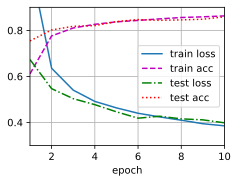

In [4]:
batch_size, lr = 256, 0.1
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

train(net, train_iter, test_iter, loss, 10, trainer)

## 5. 简洁实现

In [5]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(dropout1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(dropout2),
    nn.Linear(num_hiddens2, num_outputs)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

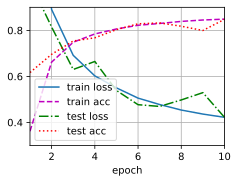

In [6]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, loss, 10, trainer)

## 6. 小结

- 暂退法在前向传播过程中，计算每一内部层的同时丢弃一些神经元。
- 暂退法可以避免过拟合，它通常与控制权重向量的维数和大小结合使用。
- 暂退法将活性值h替换为具有期望值h的随机变量。
- 暂退法仅在训练期间使用。

## 7. 练习

1. 如果更改第一层和第二层的暂退法概率，会发生什么情况？

In [25]:
def draw(dropout1, dropout2, num_epochs):
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(num_hiddens1, num_hiddens2),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(num_hiddens2, num_outputs)
    )
    
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
    
    net.apply(init_weights)
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train(net, train_iter, test_iter, loss, num_epochs, trainer)

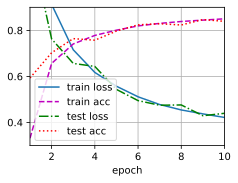

In [26]:
draw(0.2, 0.5, 10)

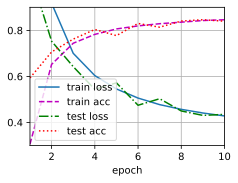

In [27]:
draw(0.5, 0.2, 10)

2. 增加训练轮数，并将使用暂退法和不使用暂退法做比较。

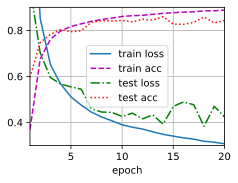

In [33]:
draw(0, 0, 30)

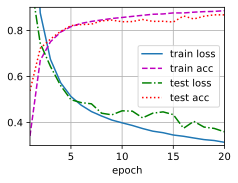

In [35]:
draw(0.1, 0.1, 30)

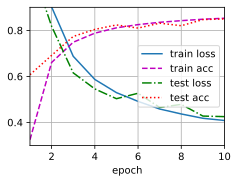

In [28]:
draw(0.2, 0.2, 10)

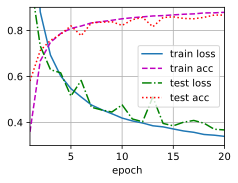

In [30]:
draw(0.2, 0.5, 30)

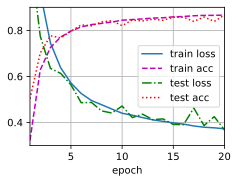

In [36]:
draw(0.5, 0.5, 30)

从上面的4个实验发现，dropout越小，越早地发生过拟合。

3. 当应用或不应用暂退法时，每个隐藏层中激活值的方差是多少？绘制曲线，显示两个模型每个隐藏层中激活值的方差如何随时间变化。

In [12]:
def train_batch(net, X, y, loss, trainer):
    l = loss(net(X), y)
    trainer.zero_grad()
    l.mean().backward()
    trainer.step()
    
def draw(num_epochs, print_point='batch'):
    dropout_vars = []
    no_dropout_vars = []
    dropout_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(num_hiddens1, num_hiddens2),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(num_hiddens2, num_outputs)
    )
    no_dropout_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Linear(num_hiddens1, num_hiddens2),
        nn.ReLU(),
        nn.Linear(num_hiddens2, num_outputs)
    )

    def forward_hook(m, fea_in, fea_out):
        if type(m) == nn.Dropout:
            dropout_vars.append(torch.var(fea_out).detach().numpy())
        if type(m) == nn.ReLU:
            no_dropout_vars.append(torch.var(fea_out).detach().numpy())
        return None
            
    for child in dropout_net.children():
        if isinstance(child, nn.Dropout):
            child.register_forward_hook(hook=forward_hook)

    for child in no_dropout_net.children():
        if isinstance(child, nn.ReLU):
            child.register_forward_hook(hook=forward_hook)
    
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    dropout_net.apply(init_weights)
    no_dropout_net.apply(init_weights)

    dropout_trainer = torch.optim.SGD(dropout_net.parameters(), lr=lr)
    no_dropout_trainer = torch.optim.SGD(no_dropout_net.parameters(), lr=lr)
    batch = 0
    animator = d2l.Animator(xlabel=print_point, ylabel='var', 
                            legend=['dropout h1', 'dropout h2', 'no dropout h1', 'no dropout h2'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            batch += 1
            train_batch(dropout_net, X, y, loss, dropout_trainer)
            train_batch(no_dropout_net, X, y, loss, no_dropout_trainer)
            assert len(dropout_vars) == batch * 2
            assert len(no_dropout_vars) == batch * 2
            if print_point=='batch':
                animator.add(batch, (dropout_vars[-2], dropout_vars[-1], no_dropout_vars[-2], no_dropout_vars[-1]))
        assert len(dropout_vars) == batch * 2
        assert len(no_dropout_vars) == batch * 2
        if print_point=='epoch':
            animator.add(epoch+1, (dropout_vars[-2], dropout_vars[-1], no_dropout_vars[-2], no_dropout_vars[-1]))

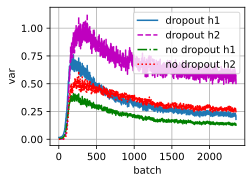

In [14]:
draw(10, 'batch')

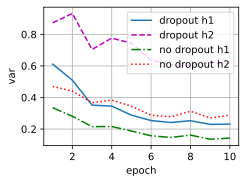

In [13]:
draw(10, 'epoch')

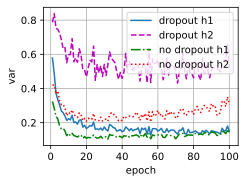

In [15]:
draw(100, 'epoch')

4. 为什么在测试时通常不使用暂退法？

   dropout 只影响模型参数的更新，测试时不更新模型参数；从另一个方面来说，测试时不使用 dropout 可以保证确定性的输出。

5. 以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？

In [31]:
num_inputs, num_outputs = 784, 10
num_hiddens = [256, 256]
batch_size, lr, num_epochs = 256, 0.1, 30
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
            
def mlp_net(dropout=False):
    net = nn.Sequential(nn.Flatten())
    num_features_in = num_inputs
    for num_features_out in num_hiddens:
        net.append(nn.Linear(num_features_in, num_features_out))
        net.append(nn.ReLU())
        if dropout:
            net.append(nn.Dropout(0.5))
        num_features_in = num_features_out
    net.append(nn.Linear(num_features_in, num_outputs))
        
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
    
    net.apply(init_weights)
    print(net)
    return net

def train_5(wd, dropout=False):
    """use weight decay"""
    net = mlp_net(dropout=dropout)
    trainer = torch.optim.SGD(params=net.parameters(), weight_decay=wd, lr=lr)
    train(net, train_iter, test_iter, loss, num_epochs, trainer)

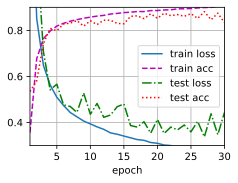

In [32]:
train_5(0, False)

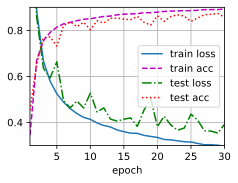

In [33]:
train_5(0.001, False)

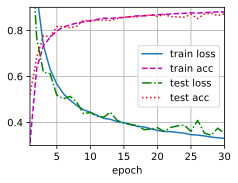

In [34]:
train_5(0, True)

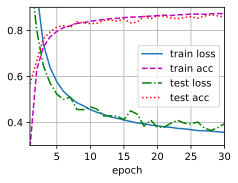

In [35]:
train_5(0.001, True)

Weight Decay和Dropout都让训练的速度变慢了一些，但是泛化损失会变好，而且看起来Dropout比Weight Decay效果好一些。
叠加使用的话没有互相抵消效果，但训练的速度更慢了，泛化的效果看起来还不错，需要训练更多的epoch。